<div class="alert alert-block alert-info">
<b>Question 1:</b>
<br>
Data Analysis of Limit Order Book
</div>

## Import Libraries

In [1]:
import scipy.io as sio  # for loading matlab data

import pandas as pd     # to analyse data using dataframes

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Load Data

In [2]:
data = sio.loadmat('EBAY_20141104.mat')

In [3]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
MO=np.array(LOB['MO'][0][0]*1.0)
dt = t[1]-t[0]

## Defining Midprice, Microprice and Spread

In [4]:
midprice = 0.5*(bid[:,0]+ask[:,0])
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
spread = ask[:,0]-bid[:,0]

### Midprice

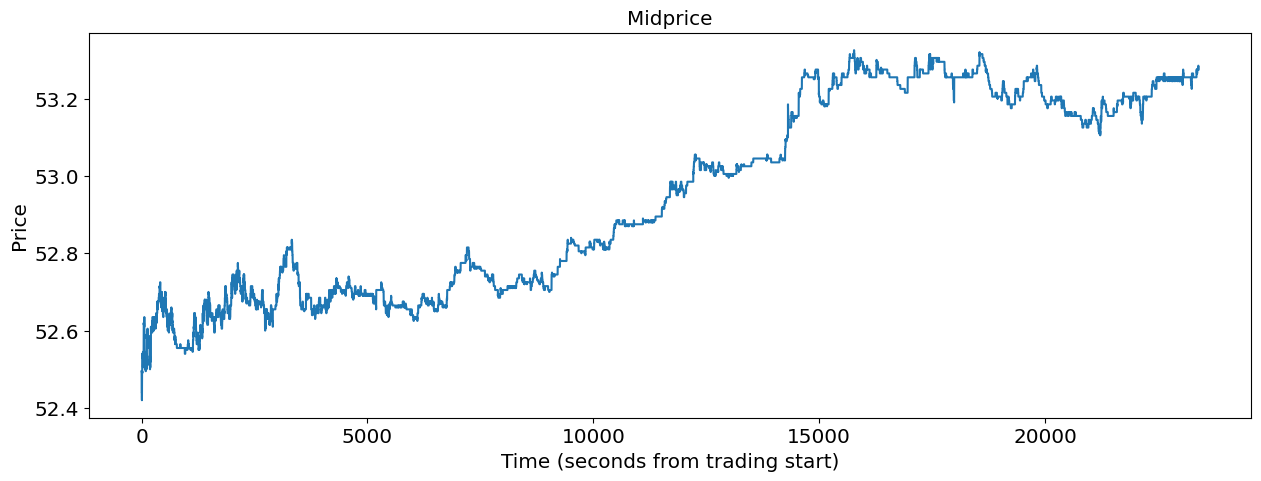

In [5]:
plt.plot(t, midprice)
plt.title('Midprice')
plt.ylabel('Price')
plt.xlabel('Time (seconds from trading start)')
plt.show()

In [6]:
data_midprice = pd.DataFrame(midprice)
data_midprice.describe()

,0
count,234000.000000
mean,52.950931
std,0.249608
min,52.420000
25%,52.705000
50%,52.945000
75%,53.205000
max,53.325000


### Microprice

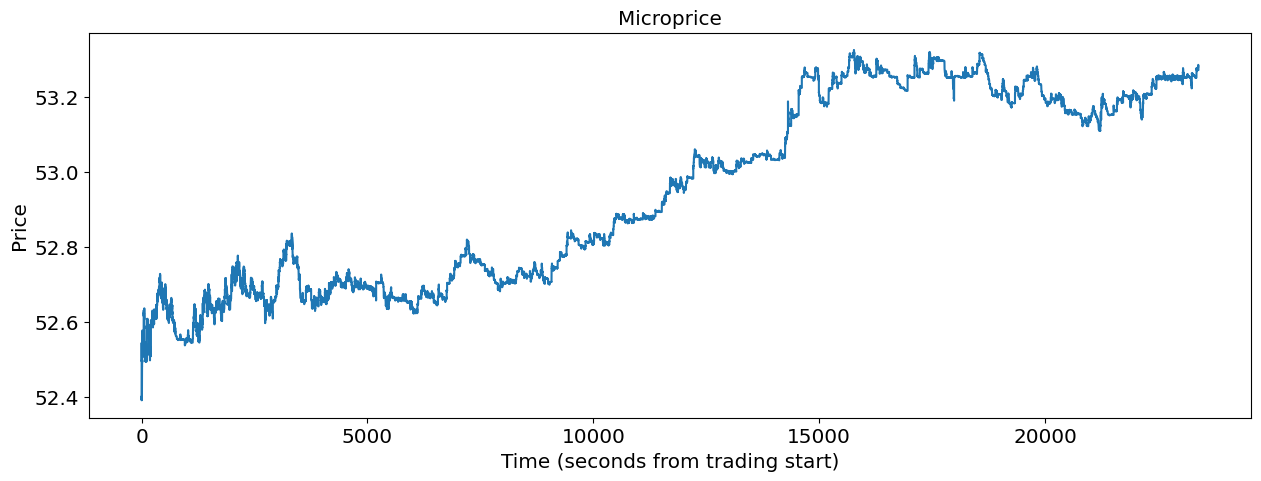

In [7]:
plt.plot(t, microprice)
plt.title('Microprice')
plt.ylabel('Price')
plt.xlabel('Time (seconds from trading start)')
plt.show()

In [8]:
data_microprice = pd.DataFrame(microprice)
data_microprice.describe()

,0
count,234000.000000
mean,52.949460
std,0.249696
min,52.390288
25%,52.703163
50%,52.947143
75%,53.207619
max,53.324043


### Difference between Microprice and Midprice

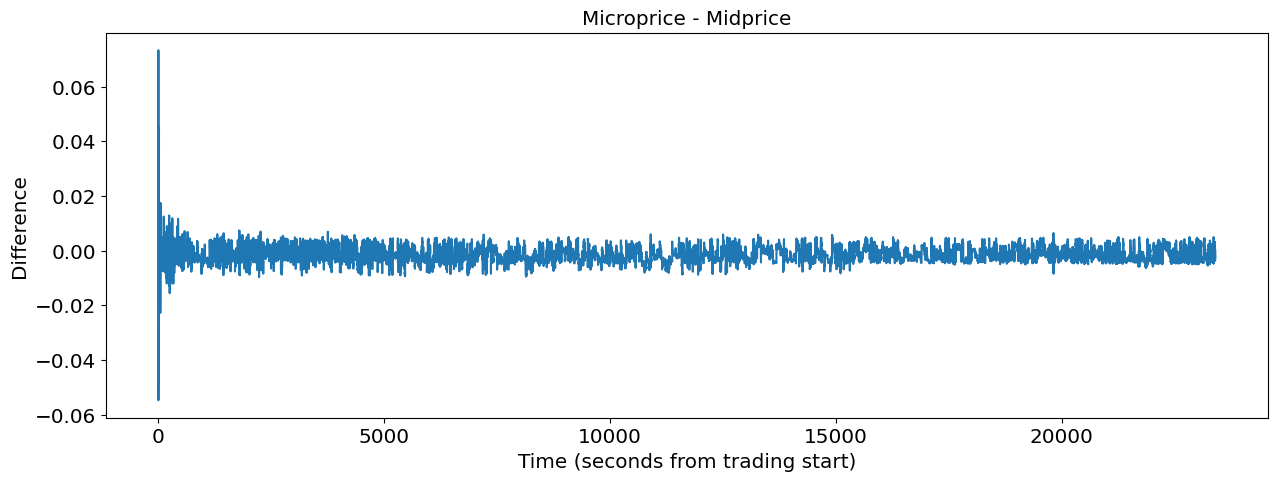

In [9]:
plt.plot(t, microprice-midprice)
plt.title('Microprice - Midprice')
plt.ylabel('Difference')
plt.xlabel('Time (seconds from trading start)')
plt.show()

In [10]:
data_micromidprice = pd.DataFrame(microprice-midprice)
data_micromidprice.describe()

,0
count,234000.000000
mean,-0.001471
std,0.002644
min,-0.054712
25%,-0.003353
50%,-0.001649
75%,0.000293
max,0.073333


### Spread

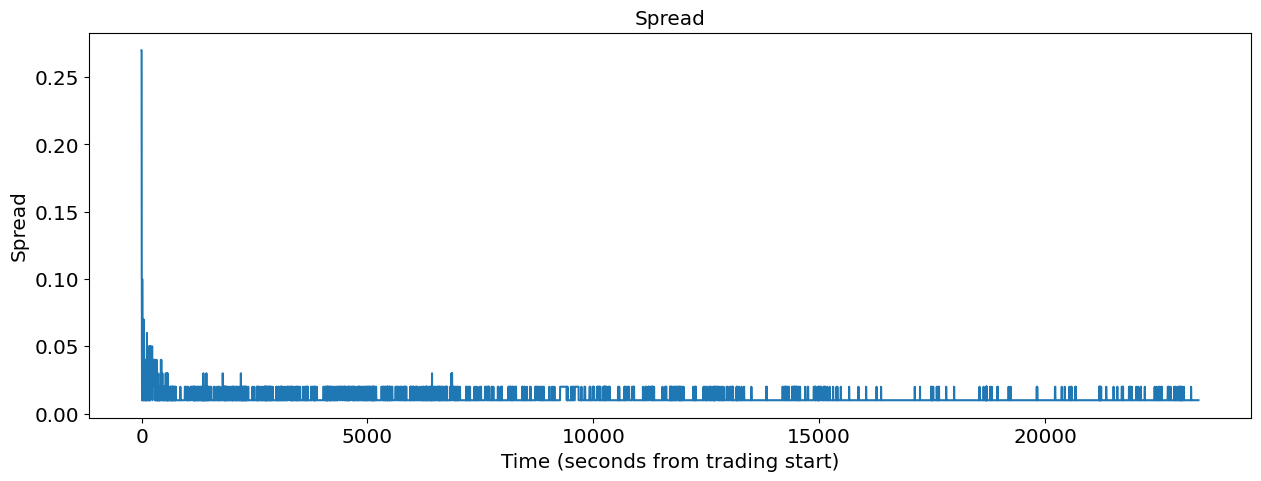

In [11]:
plt.plot(t,spread)
plt.title('Spread')
plt.ylabel('Spread')
plt.xlabel('Time (seconds from trading start)')
plt.show()

In [12]:
data_spread = pd.DataFrame(spread)
data_spread.describe()

,0
count,234000.000000
mean,0.011768
std,0.004752
min,0.010000
25%,0.010000
50%,0.010000
75%,0.010000
max,0.270000


### Plot Histogram of Spread

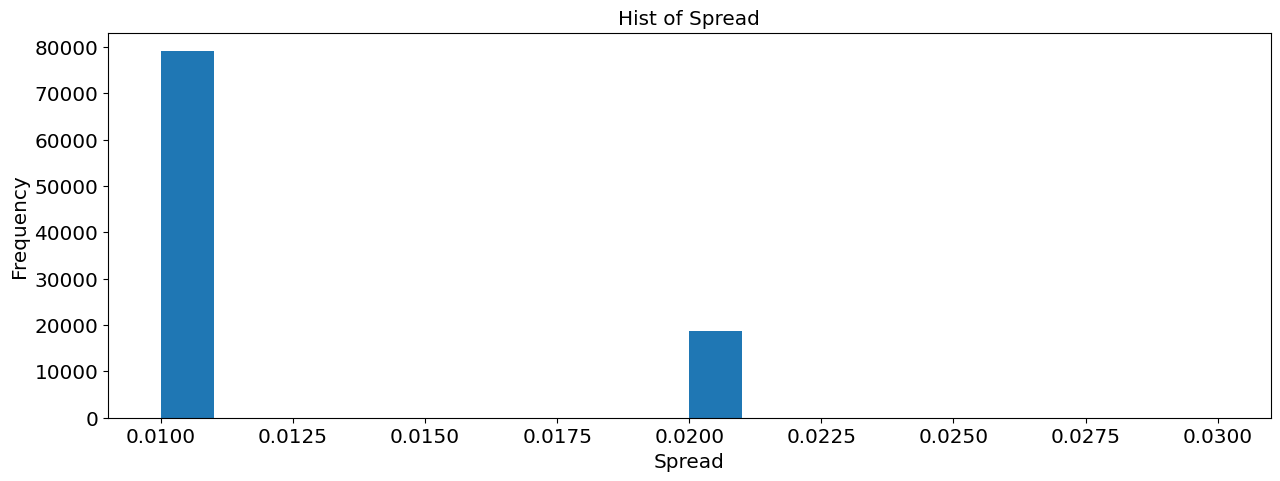

In [13]:
plt.hist(spread,bins=[0.01,0.02,0.03], width=0.001,align='mid') 
plt.title("Hist of Spread")
plt.xlabel(r'Spread')
plt.ylabel('Frequency')
plt.show()

## Volume Imbalance at Times of Limit Order

In [14]:
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

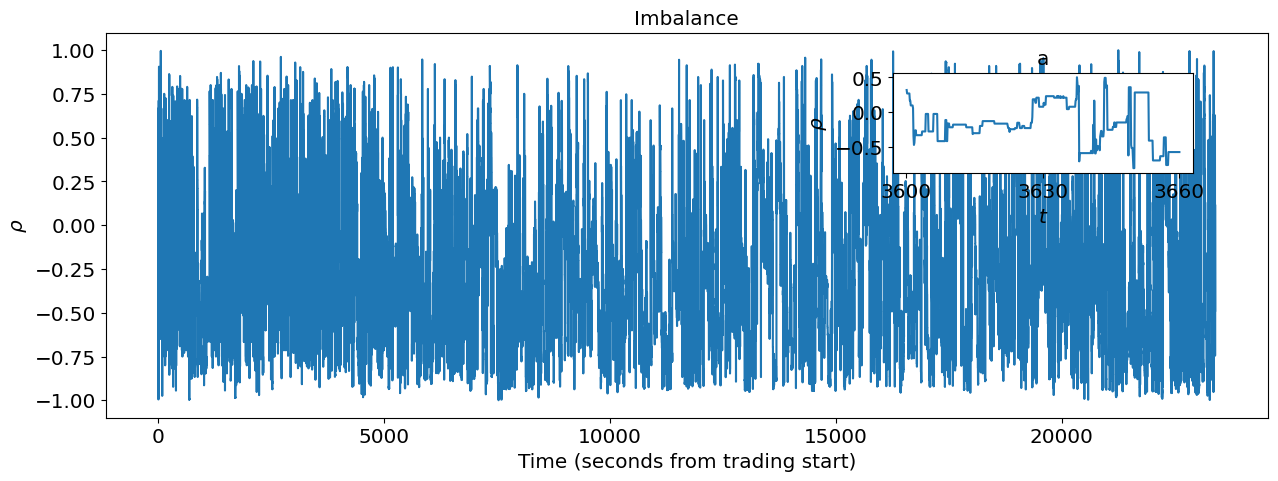

In [15]:
plt.plot(t, rho)
plt.title('Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('Time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>3600) & (t<=3600+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([3600,3630,3660])

plt.show()

In [16]:
data_imbalance = pd.DataFrame(rho)
data_imbalance.describe()

,0
count,234000.000000
mean,-0.250338
std,0.427792
min,-0.999167
25%,-0.600000
50%,-0.292377
75%,0.056338
max,0.998751


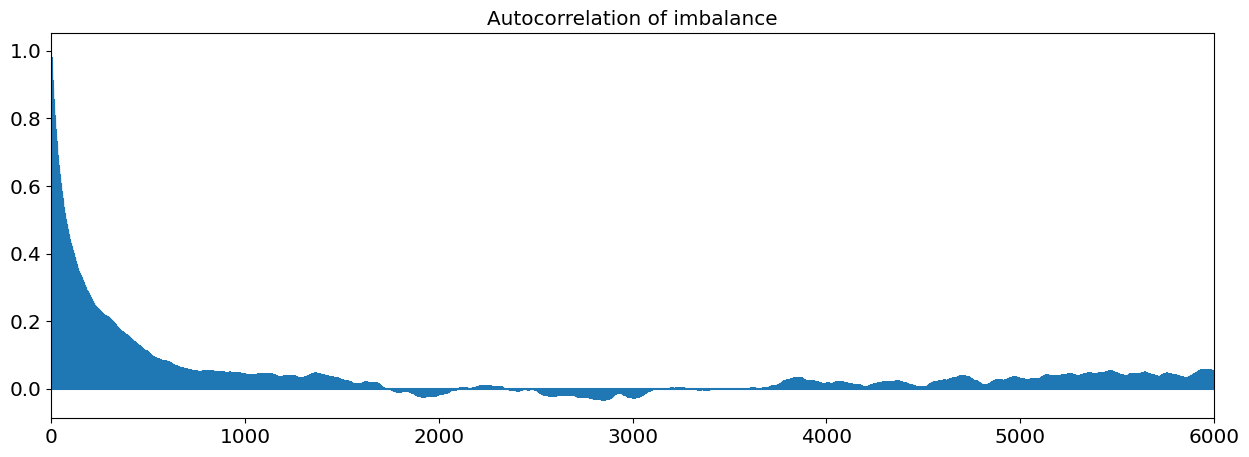

In [17]:
plt.acorr(rho[:,0]-np.mean(rho[:,0]),maxlags=6000)  # maximum one minute 
plt.title('Autocorrelation of imbalance')
plt.xlim([0,6000])
plt.show()

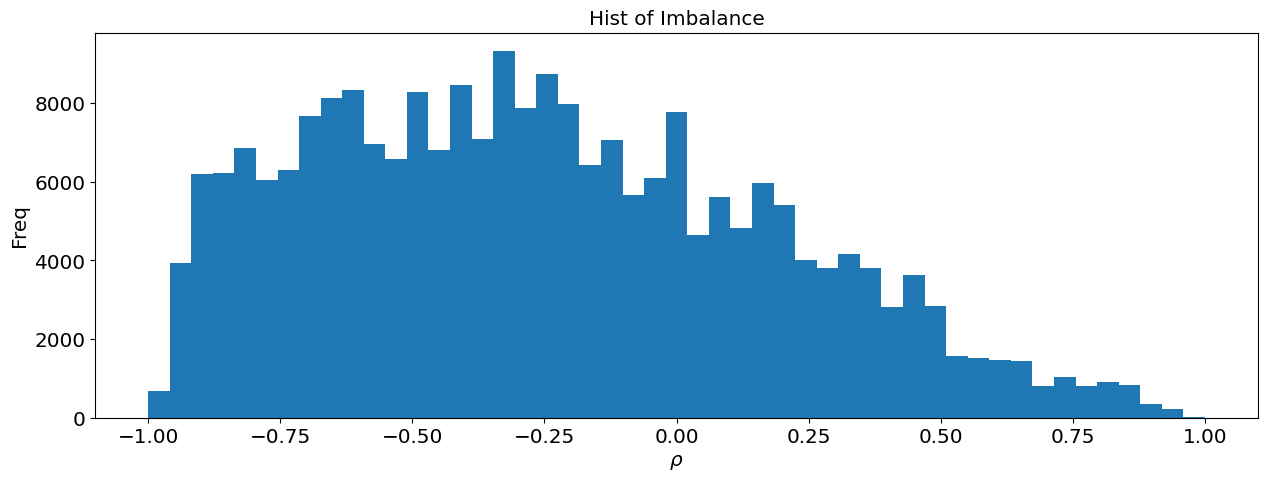

In [18]:
plt.hist(rho, bins=np.linspace(-1, 1, num=50)) 
plt.title("Hist of Imbalance")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

## Volume Imbalance at Times of Market Orders

In [19]:
rho_MO = (MO[:,3]-MO[:,4])/(MO[:,3]+MO[:,4])

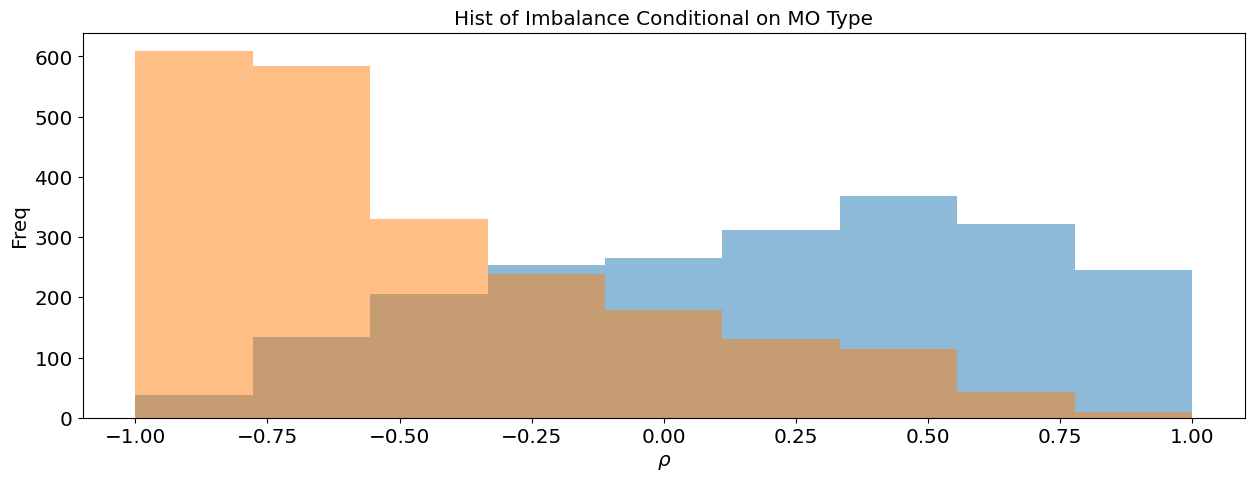

In [20]:
plt.hist(rho_MO[MO[:,7]==-1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.hist(rho_MO[MO[:,7]==+1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.title("Hist of Imbalance Conditional on MO Type")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

<div class="alert alert-block alert-info">
<b>Question 2:</b>
<br>
Share Liquidation Using only MOs
</div>

# Optimal Trading Speed and Inventory

## Parameter Settings

In [21]:
S0 = 52.42
N = 10000
T = 1
k = 0.0008
b = 0.0016
M = 23400
alpha = 0.02
phi = 0.01
sigma = 0.249608

In [22]:
gamma = np.sqrt(phi/k);
xi = (alpha - 0.5 * b + np.sqrt(k * phi))/(alpha - 0.5 * b - np.sqrt(k * phi));

In [23]:
tt = np.linspace(0, 1, M + 1)

In [24]:
v = np.zeros((M + 1, 1))
q = np.zeros((M + 1, 1))
v[0] = 0
q[0] = N  
for t in range(1, M + 1): 
    v[t] = gamma * (xi * np.exp(gamma * (T-tt[t-1])) + np.exp(- gamma * (T-tt[t-1]))) / (xi * np.exp(gamma * (T-tt[t-1])) - np.exp(- gamma * (T-tt[t-1]))) * q[t-1] * T/M
    q[t] = (xi * np.exp(gamma * (T-tt[t-1])) - np.exp(- gamma * (T-tt[t-1]))) / (xi * np.exp(gamma * T) - np.exp(- gamma * T)) * N

Text(0.5, 1.0, 'Trading Speed')

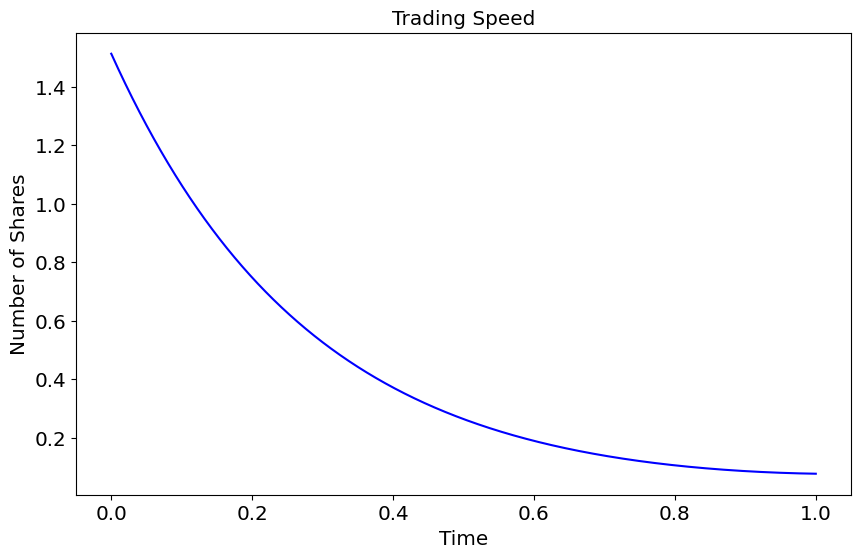

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], v[1:], 'b', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Number of Shares')
plt.title('Trading Speed')

Text(0.5, 1.0, 'Inventory')

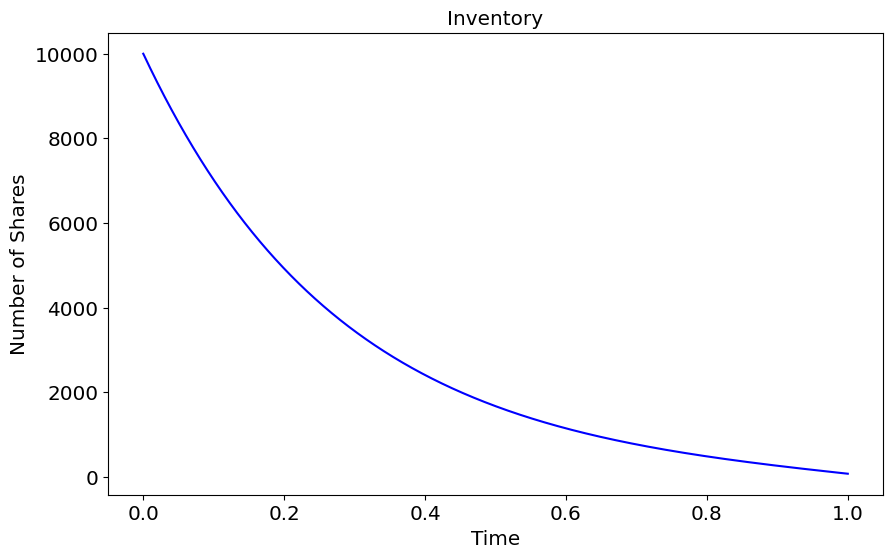

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(tt, q, 'b', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Number of Shares')
plt.title('Inventory')

# Various Levels of Running Penalty

## Import Libraries

In [27]:
import numpy as np
import import_ipynb
import Liquidation_Permanent_Price_Impact_helper as lppi_helpers

importing Jupyter notebook from Liquidation_Permanent_Price_Impact_helper.ipynb


## Setting the Parameters

In [28]:
R = 1000
T = 1
Ndt = 6.5 * 3600 # 6500hrs * 3600
dt = T / Ndt
t = np.arange(0, T + dt, dt) 

k = 0.0008 # temporary price impact
b = 0.0016 # permanent price impart

tau = T - t
tt = np.arange(0, 1 + 1 / 10, 1 / 10)

phi = 0.001
myphi = np.array([1e-6, 0.001, 0.01, 0.1, 0.5])
symb = np.array(["o", "*", "+", "^", "x"])

alpha = 0.02
myalpha = np.array([0.001, 0.004, 0.01])  

## Variations of Running Penalty

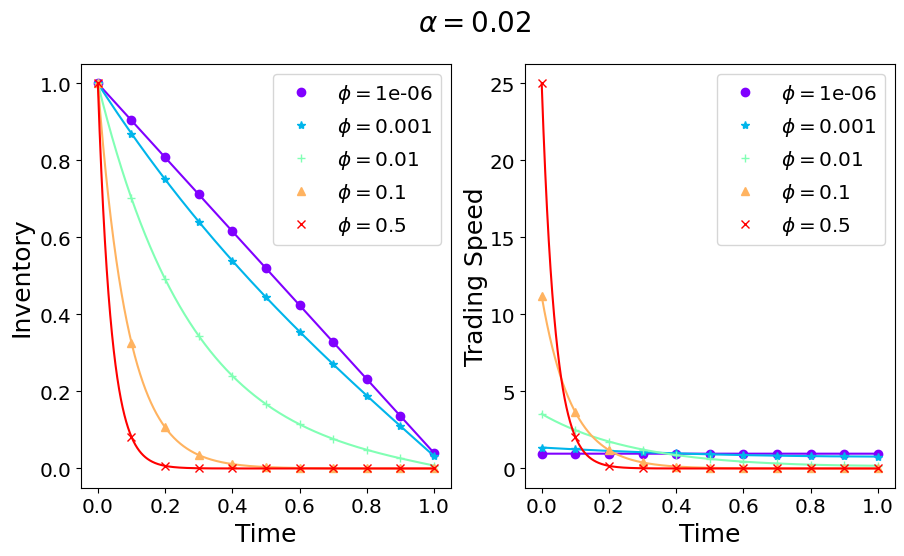

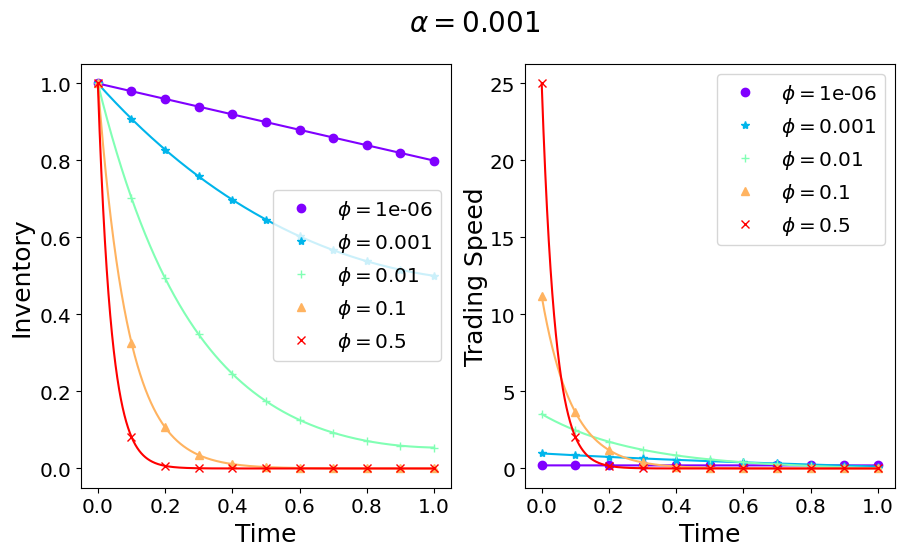

In [29]:
lppi_helpers.plot_inventory_trading_speed(alpha, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = 0.02$")
lppi_helpers.plot_inventory_trading_speed(0.001, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = 0.001$")

## Infinite Liquidation Penalty

In [30]:
# Parameter Settings
a = np.array([1, 0.8, 0.6])
k = 0.0008
b = 0.0016

phi = 10 * k
alpha = 100 * k
T = 1
qmax = 1

Ndt = 10000
Ndq = 100

dt = T / Ndt
dq = qmax / Ndq

In [31]:
nus, Qs, myleg, t, q = lppi_helpers.solve_pde(T, dt, qmax, dq, k, a, b, alpha, phi, Ndt, Ndq)

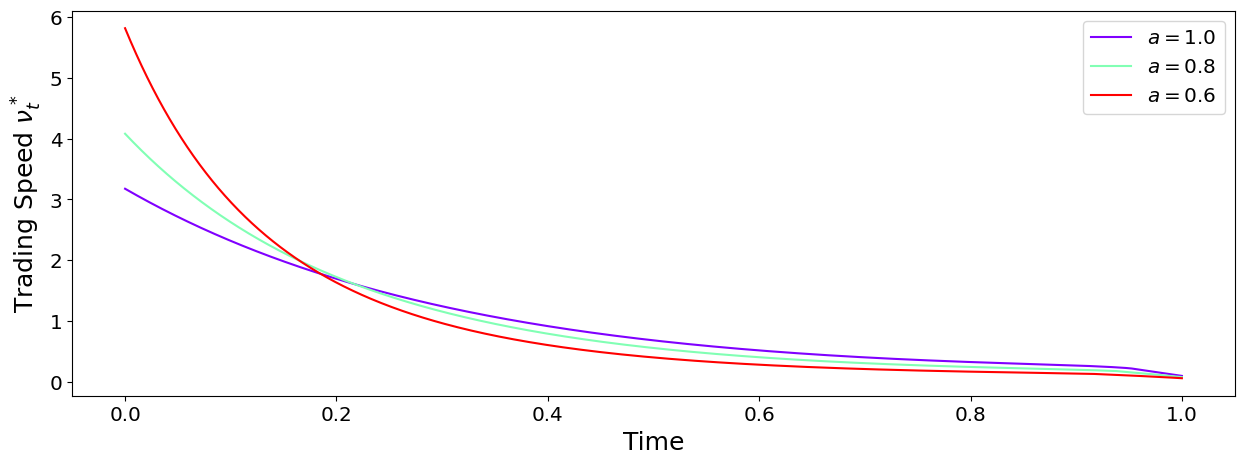

In [32]:
lppi_helpers.plot_multiple(t, nus.T, r"Time", r"Trading Speed $\nu^*_t$", None, myleg)

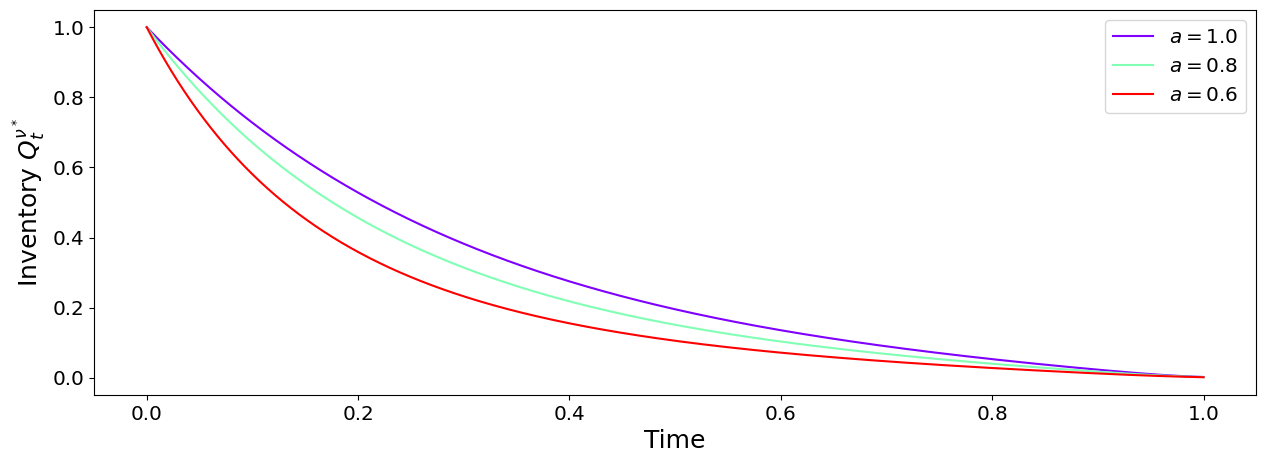

In [33]:
lppi_helpers.plot_multiple(t, Qs.T, r"Time", r"Inventory $Q_t^{\nu^*}$", None, myleg)